In [42]:
#Imports
import time
import re
from urllib.parse import urljoin
import requests
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#Cleaning plots
sns.set(style='whitegrid')

In [43]:
#Base URL to Scrape
BASE = 'https://books.toscrape.com/'

#Session to reuse for multiple requests
SESSION = requests.Session()

#Function to fetch and parse a web page
def get_soup(url, pause=0.2):
    resp = SESSION.get(url)
    resp.raise_for_status()
    time.sleep(pause)
    return BeautifulSoup(resp.text, 'lxml')

# Convert textual star ratings into numeric values 
def rating_to_int(r):
    mapping = {'One':1, 'Two':2, 'Three':3, 'Four':4, 'Five':5}
    return mapping.get(r, None)

In [44]:
#Empty list to store book data
books = []

#Start scraping
page_url = urljoin(BASE, 'catalogue/page-1.html')

#Loop through all pages
while True:
    print('Scraping:', page_url)
    soup = get_soup(page_url)
    entries = soup.select('article.product_pod')

    #Extract data for each book
    for e in entries:
        a = e.find('h3').find('a')
        title = a['title']
        rel = a['href']
        link = urljoin(page_url, rel)
        price = e.select_one('.price_color').text.strip()
        rating_tag = e.select_one('p.star-rating')
        rating_word = [c for c in rating_tag['class'] if c != 'star-rating'][0]
        # Save book info
        books.append({'title': title, 'url': link, 'price_raw': price, 'rating_word': rating_word})

    #Check if there’s a link to the next page
    nxt = soup.select_one('li.next > a')
    if not nxt:
        break
    page_url = urljoin(page_url, nxt['href'])

#Print total number of books scraped
print('Found', len(books), 'books.')

Scraping: https://books.toscrape.com/catalogue/page-1.html
Scraping: https://books.toscrape.com/catalogue/page-2.html
Scraping: https://books.toscrape.com/catalogue/page-3.html
Scraping: https://books.toscrape.com/catalogue/page-4.html
Scraping: https://books.toscrape.com/catalogue/page-5.html
Scraping: https://books.toscrape.com/catalogue/page-6.html
Scraping: https://books.toscrape.com/catalogue/page-7.html
Scraping: https://books.toscrape.com/catalogue/page-8.html
Scraping: https://books.toscrape.com/catalogue/page-9.html
Scraping: https://books.toscrape.com/catalogue/page-10.html
Scraping: https://books.toscrape.com/catalogue/page-11.html
Scraping: https://books.toscrape.com/catalogue/page-12.html
Scraping: https://books.toscrape.com/catalogue/page-13.html
Scraping: https://books.toscrape.com/catalogue/page-14.html
Scraping: https://books.toscrape.com/catalogue/page-15.html
Scraping: https://books.toscrape.com/catalogue/page-16.html
Scraping: https://books.toscrape.com/catalogue/pa

In [46]:
#Loop through each scraped book entry for more details
for i, b in enumerate(books):
    try:
        soup = get_soup(b['url'])
    except Exception as e:
        print('Skip', b['url'], e)
        continue

    #Determine the book category
    breadcrumb = [li.text.strip() for li in soup.select('.breadcrumb li')]
    category = breadcrumb[-2] if len(breadcrumb) >= 3 else None

    #Extract availability
    avail = soup.select_one('.instock.availability').text.strip()
    m = re.search(r'(\d+)', avail)
    num = int(m.group(1)) if m else None

    # Extract book description
    desc_tag = soup.find('div', id='product_description')
    desc = desc_tag.find_next('p').text.strip() if desc_tag else ''

    # Update this book’s dictionary
    b.update({
        'category': category,
        'availability': avail,
        'num_available': num,
        'description': desc
    })

    # Print progress every 100 books processed
    if (i + 1) % 25 == 0:
        print('Processed', i + 1)

Processed 25
Processed 50
Processed 75
Processed 100
Processed 125
Processed 150
Processed 175
Processed 200
Processed 225
Processed 250
Processed 275
Processed 300
Processed 325
Processed 350
Processed 375
Processed 400
Processed 425
Processed 450
Processed 475
Processed 500
Processed 525
Processed 550
Processed 575
Processed 600
Processed 625
Processed 650
Processed 675
Processed 700
Processed 725
Processed 750
Processed 775
Processed 800
Processed 825
Processed 850
Processed 875
Processed 900
Processed 925
Processed 950
Processed 975
Processed 1000


In [47]:
#Convert the list of dictionaries into a Pandas DataFrame
df = pd.DataFrame(books)

#Parse prices
def parse_price(t):
    try:
        return float(t.replace('£', '').strip())
    except:
        return None

#Apply cleaning and feature extraction
df['price_gbp'] = df['price_raw'].apply(parse_price)
df['rating'] = df['rating_word'].apply(rating_to_int)
df['desc_len'] = df['description'].apply(lambda x: len(x))

#Remove duplicate entries
df.drop_duplicates('url', inplace=True)
df.reset_index(drop=True, inplace=True)

#Print dataset dimensions and preview the first rows
print('Shape:', df.shape)
df.head()


Shape: (1000, 11)


,title,url,price_raw,rating_word,category,availability,num_available,description,price_gbp,rating,desc_len
0,A Light in the Attic,https://books.toscrape.com/catalogue/a-light-i...,Â£51.77,Three,Poetry,In stock (22 available),22,It's hard to imagine a world without A Light i...,None,3,1017
1,Tipping the Velvet,https://books.toscrape.com/catalogue/tipping-t...,Â£53.74,One,Historical Fiction,In stock (20 available),20,"""Erotic and absorbing...Written with starling ...",None,1,1029
2,Soumission,https://books.toscrape.com/catalogue/soumissio...,Â£50.10,One,Fiction,In stock (20 available),20,"Dans une France assez proche de la nÃ´tre, un ...",None,1,1136
3,Sharp Objects,https://books.toscrape.com/catalogue/sharp-obj...,Â£47.82,Four,Mystery,In stock (20 available),20,"WICKED above her hipbone, GIRL across her hear...",None,4,1647
4,Sapiens: A Brief History of Humankind,https://books.toscrape.com/catalogue/sapiens-a...,Â£54.23,Five,History,In stock (20 available),20,From a renowned historian comes a groundbreaki...,None,5,1969


In [48]:
#Display DataFrame structure and column data types
print(df.info())

#Show how many missing values exist
print('\nMissing values:')
print(df.isna().sum())

#Display basic statistics
print('\nDescription:')
print(df[['price_gbp','rating','num_available','desc_len']].describe())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   title          1000 non-null   object
 1   url            1000 non-null   object
 2   price_raw      1000 non-null   object
 3   rating_word    1000 non-null   object
 4   category       1000 non-null   object
 5   availability   1000 non-null   object
 6   num_available  1000 non-null   int64 
 7   description    1000 non-null   object
 8   price_gbp      0 non-null      object
 9   rating         1000 non-null   int64 
 10  desc_len       1000 non-null   int64 
dtypes: int64(3), object(8)
memory usage: 86.1+ KB
None

Missing values:
title               0
url                 0
price_raw           0
rating_word         0
category            0
availability        0
num_available       0
description         0
price_gbp        1000
rating              0
desc_len            0
dtype: int64

Descri

In [49]:
#Convert 'price_raw' into a numeric column 'price_gbp'
df['price_gbp'] = (
    df['price_raw']
    .astype(str)
    .str.extract(r'(\d+\.\d+)')[0]
    .astype(float)
)

#Verify that conversion worked
print(df['price_gbp'].head())
print(df['price_gbp'].describe())


0    51.77
1    53.74
2    50.10
3    47.82
4    54.23
Name: price_gbp, dtype: float64
count    1000.00000
mean       35.07035
std        14.44669
min        10.00000
25%        22.10750
50%        35.98000
75%        47.45750
max        59.99000
Name: price_gbp, dtype: float64


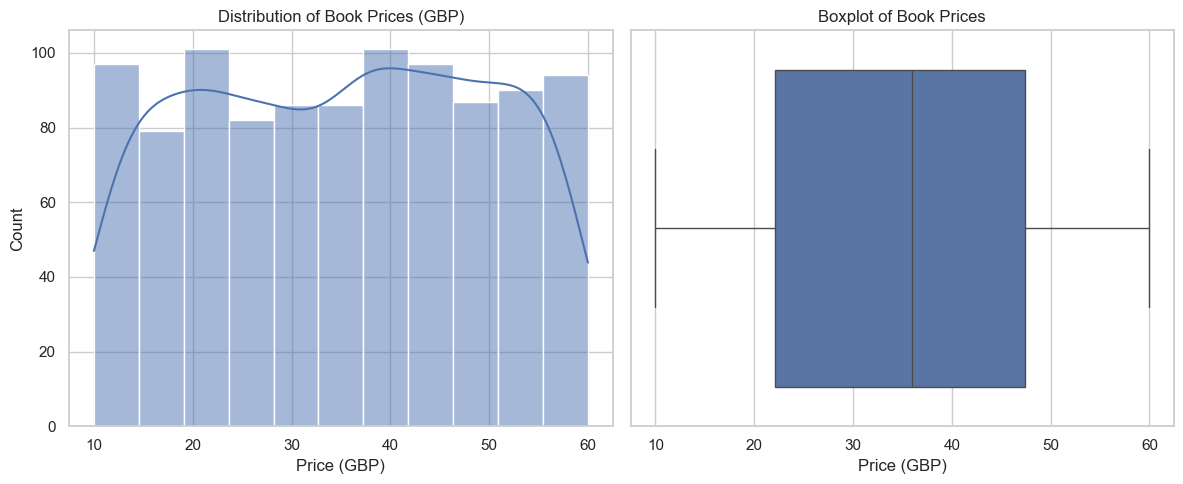

In [50]:
#Create two subplots
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

#Left Plot: Histogram
sns.histplot(df['price_gbp'], kde=True, ax=ax[0])
ax[0].set_title('Distribution of Book Prices (GBP)')
ax[0].set_xlabel('Price (GBP)')
ax[0].set_ylabel('Count')

#Right Plot: Boxplot
sns.boxplot(x=df['price_gbp'], ax=ax[1])
ax[1].set_title('Boxplot of Book Prices')
ax[1].set_xlabel('Price (GBP)')

# Adjust spacing
plt.tight_layout()

# Display
plt.show()


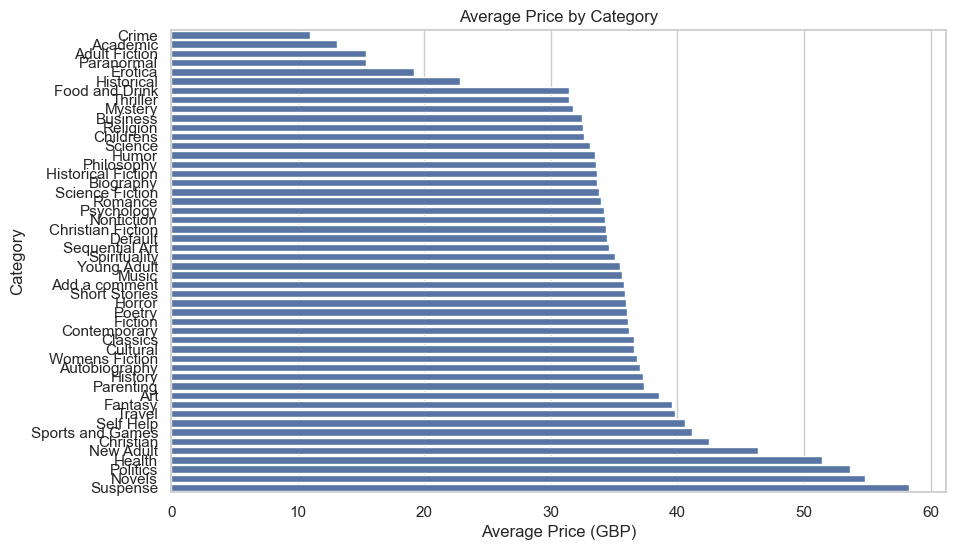

In [51]:
#Calculate average book price for each category
cat_avg = df.groupby('category')['price_gbp'].mean().sort_values()

#Create a bar plot showing average price
plt.figure(figsize=(10,6))
sns.barplot(x=cat_avg.values, y=cat_avg.index)

#Titles and labels
plt.title('Average Price by Category')
plt.xlabel('Average Price (GBP)')
plt.ylabel('Category')

#Dispay
plt.show()


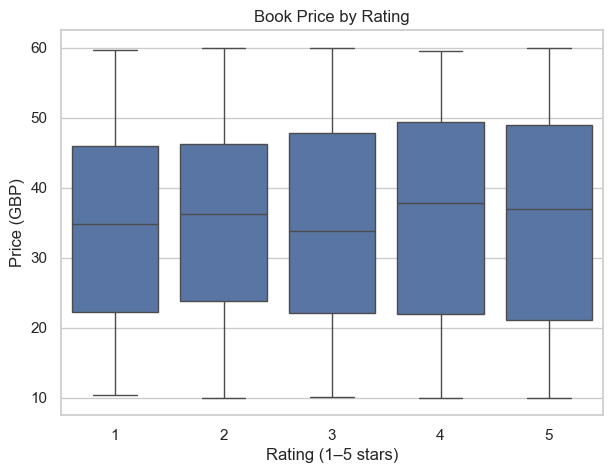

In [52]:
#Create a boxplot to compare book prices across different ratings
plt.figure(figsize=(7,5))
sns.boxplot(x='rating', y='price_gbp', data=df)

#Add titles and labels
plt.title('Book Price by Rating')
plt.xlabel('Rating (1–5 stars)')
plt.ylabel('Price (GBP)')

#Display
plt.show()


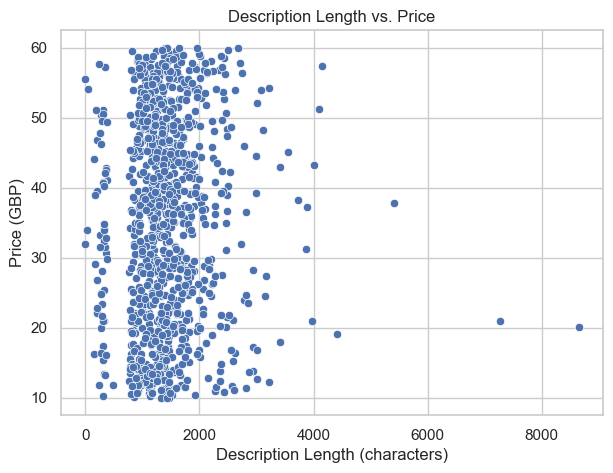

In [53]:
# Create a scatter plot to show between book description length and book price
plt.figure(figsize=(7,5))
sns.scatterplot(x='desc_len', y='price_gbp', data=df)

#Add titles and labels
plt.title('Description Length vs. Price')
plt.xlabel('Description Length (characters)')
plt.ylabel('Price (GBP)')

#Display
plt.show()
